# Merge multiple COCO annotation JSON files into one file. 

Given multiple COCO annotated JSON files, your goal is to merge them into one COCO annotated JSON file. 

A merged COCO annotated JSON file is required where all the data is in one place and it becomes easy to split it into a training and validation JSON file according to the percentage ratio. In case you already have a validated COCO annotated JSON file, then this notebook can be used to merge multiple files into one training COCO annotated JSON file. 

This notebook uses a third party library to accomplish this task. Recursion is used to combine multiple JSON files using a third party library. 

This notebook is an end to end example. When you run the notebook, it will take all the multiple JSON files and will output one JSON file.  

**Note** - In this example, we assume that all our data is saved on Google drive and we will also write our outputs to Google drive. We also assume that the script will be used as a Google Colab notebook. But this can be changed according to the needs of users. They can modify this in case they are working on their local workstation, remote server or any other database. This colab notebook can be changed to a regular jupyter notebook running on a local machine according to the need of the users.

## **MUST DO** - Install the package and restart runtime

In [ ]:
# install python object detection insights library to merge multiple COCO annotation files
!pip install pyodi

# RESTART THE RUNTIME in order to use this library

## Run the below command to connect to your google drive

In [ ]:
# import other libraries
from google.colab import drive
import pyodi
import subprocess
import sys
import os
import json
import numpy as np
import pandas as pd

In [ ]:
# connect to google drive
drive.mount('/content/gdrive')

# making an alias for the root path
try:
  !ln -s /content/gdrive/My\ Drive/ /mydrive
  print('Successful')
except Exception as e:
  print(e)
  print('Not successful')

Mounted at /content/gdrive
Successful


## Visualization function

In [ ]:
def data_creation(path: str) -> pd.DataFrame:
  """Create a dataframe with the occurences of images and categories.
  Args:
    path: path to the annotated JSON file.
  Returns:
    dataset consisting of the counts of images and categories.
  """
  # get annotation file data into a variable
  with open(path) as json_file:
    data = json.load(json_file)

  # count the occurance of each category and an image in the annotation file
  category_names = [i['name'] for i in data['categories']]
  category_ids = [i['category_id'] for i in data['annotations']]
  image_ids = [i['image_id'] for i in data['annotations']]

  # create a dataframe
  df = pd.DataFrame(
      list(zip(category_ids, image_ids)), columns=['category_ids', 'image_ids'])
  df = df.groupby('category_ids').agg(
      object_count=('category_ids', 'count'),
      image_count=('image_ids', 'nunique'))
  df = df.reindex(range(1, len(data['categories']) + 1), fill_value=0)
  df.index = category_names
  return df

def visualize_detailed_counts_horizontally(path: str) -> None:
  """Plot a vertical bar graph showing the counts of images & categories.
  Args:
    path: path to the annotated JSON file.
  """
  df = data_creation(path)
  ax = df.plot(
      kind='bar',
      figsize=(40, 10),
      xlabel='Categories',
      ylabel='Counts',
      width=0.8,
      linewidth=1,
      edgecolor='white')  # rot = 0 for horizontal labeling
  for p in ax.patches:
    ax.annotate(
        text=np.round(p.get_height()),
        xy=(p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='top',
        xytext=(4, 14),
        textcoords='offset points')

## Define the paths of inputs and outputs

In [ ]:
def list_full_paths(directory):
    '''return the files names in a directory with absolute path.
    Args:
      directory: path where all the files that need to merge are saved.
    '''
    return [os.path.join(directory, file) for file in os.listdir(directory)]

In [ ]:
folder_with_jsons = '/mydrive/TFHub/jsons/' #@param {type:"string"}
output_merged_file = '/mydrive/TFHub/jsons/merged.json' #@param {type:"string"}

In [ ]:
# get a list of all the JSON files that need to merge with their absolute paths
list_of_json_files = list_full_paths(folder_with_jsons)
len(list_of_json_files)

8

# Merge the files

In [ ]:
def merge_two_files(file1, file2, output_file):
  """Function to merge 2 files

  Args:
    file1: path of the 1st COCO annotation json file
    file2: path of the 2nd COCO annotation json file
    output_file: path of the output COCO annotation json file after merge

  Returns:
    Path of the merged COCO annotation json file
  """
  subprocess.run(['pyodi', 'coco', 'merge', file1, file2, output_file])
  return output_file

def merge_multiple_files(list_of_files,output_file_path):
  """Recursive function to merge multiple files

  Args:
    list_of_files: list of all the COCO annotation json files that need to be merged 
    output_file_path: path of the output COCO annotation json file after merge

  Returns:
    Path of the merged COCO annotation json file
  """
  if len(list_of_files) == 2:
    return merge_two_files(list_of_files[0], list_of_files[1], output_file_path)

  else:
    return merge_two_files(list_of_files[0], merge_multiple_files(list_of_files[1:], output_file_path), output_file_path)

The output of the below code will be a merged COCO annotation file in the same directory.

In [ ]:
# call function to merge multiple files
print('Total number of files to merge :', len(list_of_json_files))
merge_multiple_files(list_of_json_files, output_merged_file)

print('Merge Done')

Total number of files to merge : 8
Merge Done


## Visualize the results

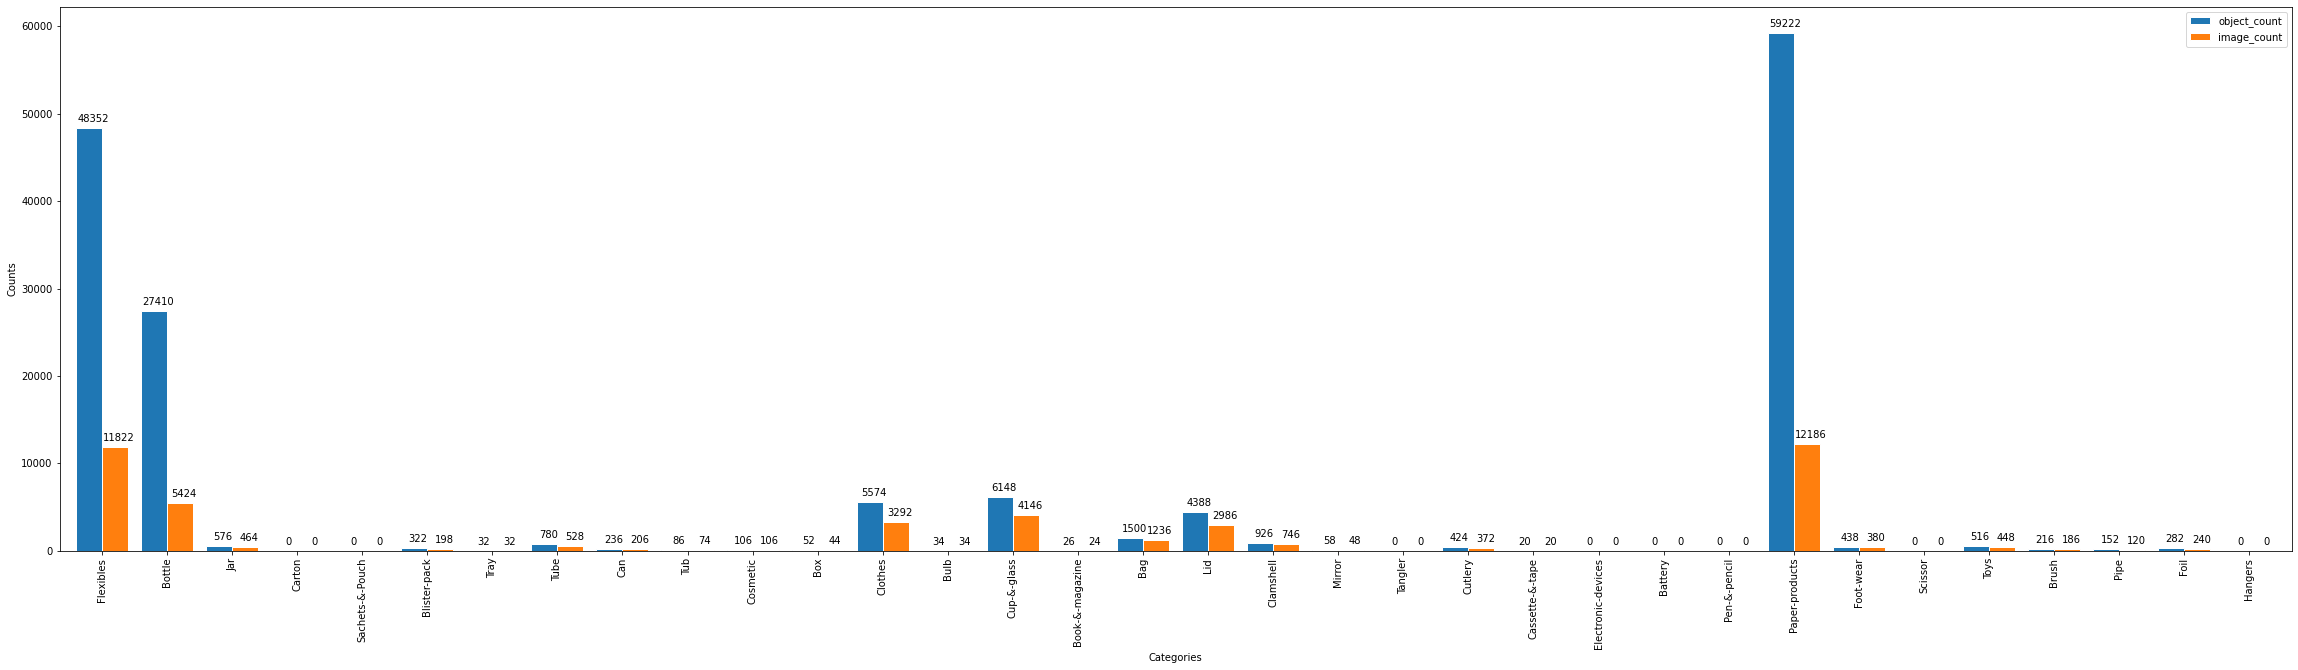

In [ ]:
# visualize the merged COCO annotated JSON file
visualize_detailed_counts_horizontally(output_merged_file)